# **Question 2**
#### **Stock Price Prediction Problem (Opening Price) Based on the Following Information:**


* Opening price, closing price, and trading volume from previous days.
* Industry type of the stock.
* Time of the year (e.g., by day, by month).
* Some macroeconomic indicators: self-selected from reliable sources (e.g., GDP, price indices, etc.).


#### **Tasks to Perform:**
1. **Experiment with the following methods:**
  * Feedforward Neural Network.
  * Recurrent Neural Network (RNN).
  * Other algorithms: Linear Regression, SVM, Decision Tree, Random Forest, etc.

2. **Apply techniques to prevent overfitting and plot training graphs.**

3. **Evaluate the models and compare them, plotting the results.**




# **Cài đặt module**

In [1]:
pip install fredapi

# **Import module**

In [2]:
import yfinance as yf
import pandas as pd
from fredapi import Fred
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
from tensorflow.keras.utils import plot_model
import seaborn as sns

# **Fetch dataset**

In [3]:
ticker_symbol = "TSLA"

ticker = yf.Ticker(ticker_symbol)
industry_type = ticker.info.get("industry")

raw_df = ticker.history(period="2y")

raw_df["Industry"] = industry_type

raw_df = raw_df.drop(['High', 'Low', "Dividends", "Stock Splits"], axis=1)

raw_df = raw_df.reset_index()

raw_df['Month'] = raw_df['Date'].dt.month
raw_df['Day'] = raw_df['Date'].dt.day
raw_df['DayOfWeek'] = raw_df['Date'].dt.day_name()
raw_df['Date'] = raw_df['Date'].dt.date

API_KEYS = "3e16e5b00201cf37675732e83de10ad2"
fred = Fred(api_key=API_KEYS)

gdp_df = fred.get_series('GDP')
gdp_df = gdp_df.reset_index()
gdp_df['index'] = gdp_df['index'].dt.date

cpi_df = fred.get_series("CPIAUCNS")
cpi_df = cpi_df.reset_index()
cpi_df['index'] = cpi_df['index'].dt.date

unrate_df = fred.get_series("UNRATE")
unrate_df = unrate_df.reset_index()
unrate_df['index'] = unrate_df['index'].dt.date

def get_nearest(date, df):
    nearest_data = df[df['index'] <= date]
    if not nearest_data.empty:
        return nearest_data.iloc[-1][0]
    return None

raw_df['GDP'] = raw_df['Date'].apply(lambda date: get_nearest(date, gdp_df))
raw_df['CPI'] = raw_df['Date'].apply(lambda date: get_nearest(date, cpi_df))
raw_df['UNRATE'] = raw_df['Date'].apply(lambda date: get_nearest(date, unrate_df))

raw_df = raw_df.drop(["Date"], axis=1)

# **Hiển thị dataset**

In [4]:
raw_df

,Open,Close,Volume,Industry,Month,Day,DayOfWeek,GDP,CPI,UNRATE
0,154.000000,149.869995,139390600,Auto Manufacturers,12,19,Monday,26734.277,296.797,3.5
1,146.050003,137.800003,159563300,Auto Manufacturers,12,20,Tuesday,26734.277,296.797,3.5
2,139.339996,137.570007,145417400,Auto Manufacturers,12,21,Wednesday,26734.277,296.797,3.5
3,136.000000,125.349998,210090300,Auto Manufacturers,12,22,Thursday,26734.277,296.797,3.5
4,126.370003,123.150002,166989700,Auto Manufacturers,12,23,Friday,26734.277,296.797,3.5
...,...,...,...,...,...,...,...,...,...,...
497,409.700012,424.769989,104287600,Auto Manufacturers,12,11,Wednesday,29354.321,315.493,4.2
498,424.839996,418.100006,87752200,Auto Manufacturers,12,12,Thursday,29354.321,315.493,4.2
499,420.000000,436.230011,89000200,Auto Manufacturers,12,13,Friday,29354.321,315.493,4.2
500,441.089996,463.019989,114083800,Auto Manufacturers,12,16,Monday,29354.321,315.493,4.2


# **Trực quan hóa dữ liệu bằng đồ thị**

* **Các thuộc tính dạng Numeric**

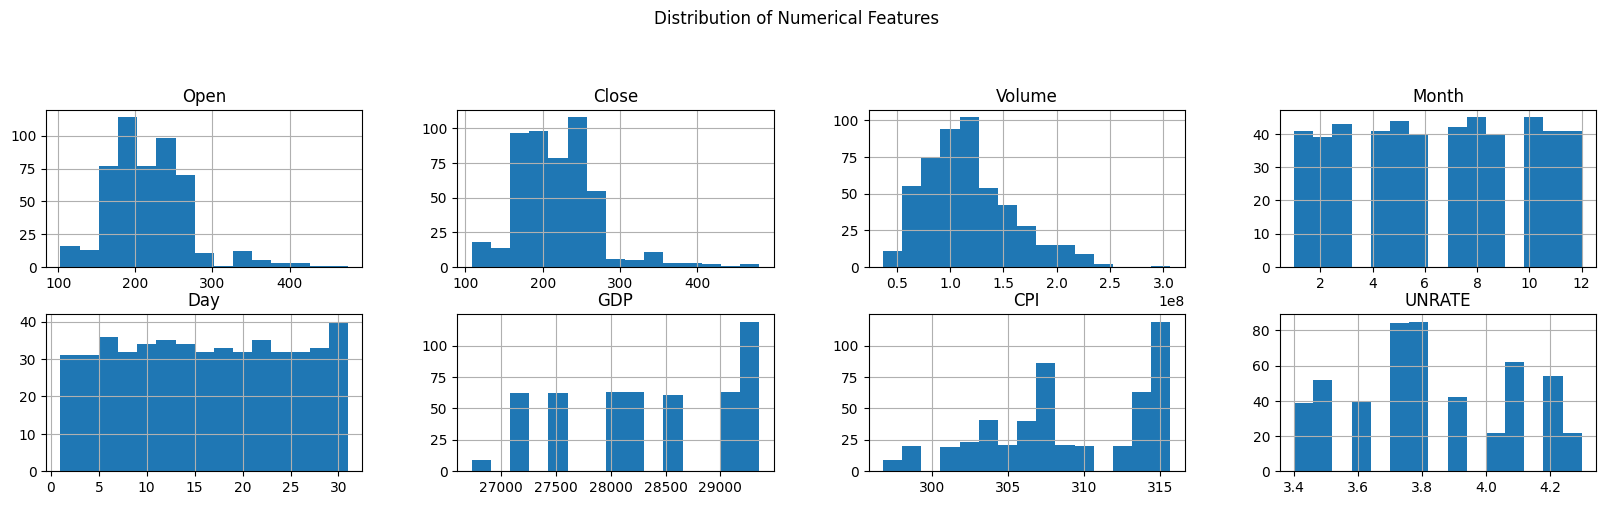

In [5]:
raw_df.hist(bins=15, figsize=(20, 10), layout=(4, 4))
plt.suptitle("Distribution of Numerical Features")
plt.show()

* **Các thuộc tính dạng Categorical**

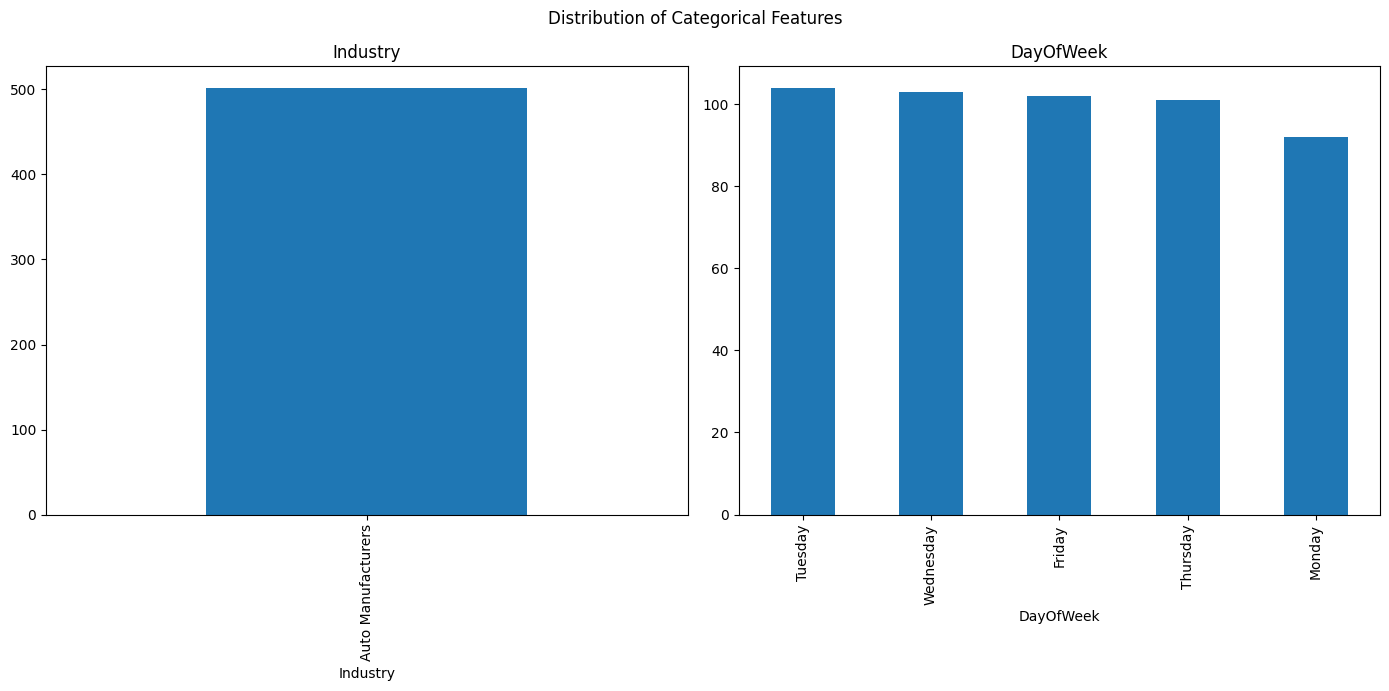

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))

raw_df["Industry"].value_counts().plot(kind="bar", ax=ax[0], title="Industry")
raw_df["DayOfWeek"].value_counts().plot(kind="bar", ax=ax[1], title="DayOfWeek")

plt.suptitle("Distribution of Categorical Features")
plt.tight_layout()
plt.show()

* **Phân bổ giá trị của biến mục tiêu**

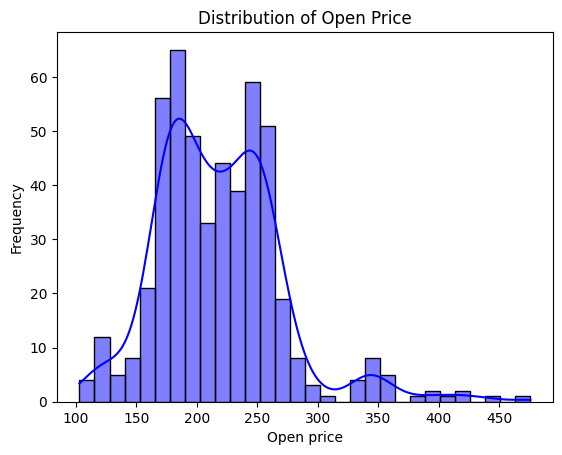

In [7]:
sns.histplot(raw_df['Open'], kde=True, bins=30, color='blue')
plt.title('Distribution of Open Price')
plt.xlabel('Open price')
plt.ylabel('Frequency')
plt.show()

# **Thông tin thuộc tính của dataset**

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   Close      502 non-null    float64
 2   Volume     502 non-null    int64  
 3   Industry   502 non-null    object 
 4   Month      502 non-null    int32  
 5   Day        502 non-null    int32  
 6   DayOfWeek  502 non-null    object 
 7   GDP        502 non-null    float64
 8   CPI        502 non-null    float64
 9   UNRATE     502 non-null    float64
dtypes: float64(5), int32(2), int64(1), object(2)
memory usage: 35.4+ KB


# **Tiền xử lý dữ liệu**

* **Kiểm tra Missing Values**

In [9]:
df = raw_df.copy()

df.isnull().sum()

,0
Open,0
Close,0
Volume,0
Industry,0
Month,0
Day,0
DayOfWeek,0
GDP,0
CPI,0
UNRATE,0


* **One hot encoding với dữ liệu Categorical**

In [10]:
df = pd.get_dummies(df, columns=["Industry", "DayOfWeek"])

df

,Open,Close,Volume,Month,Day,GDP,CPI,UNRATE,Industry_Auto Manufacturers,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,154.000000,149.869995,139390600,12,19,26734.277,296.797,3.5,True,False,True,False,False,False
1,146.050003,137.800003,159563300,12,20,26734.277,296.797,3.5,True,False,False,False,True,False
2,139.339996,137.570007,145417400,12,21,26734.277,296.797,3.5,True,False,False,False,False,True
3,136.000000,125.349998,210090300,12,22,26734.277,296.797,3.5,True,False,False,True,False,False
4,126.370003,123.150002,166989700,12,23,26734.277,296.797,3.5,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,409.700012,424.769989,104287600,12,11,29354.321,315.493,4.2,True,False,False,False,False,True
498,424.839996,418.100006,87752200,12,12,29354.321,315.493,4.2,True,False,False,True,False,False
499,420.000000,436.230011,89000200,12,13,29354.321,315.493,4.2,True,True,False,False,False,False
500,441.089996,463.019989,114083800,12,16,29354.321,315.493,4.2,True,False,True,False,False,False


* **Chuẩn hóa dữ liệu**

In [11]:
X = df.drop(['Open'], axis=1)
y = df['Open']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# **Xây dựng mô hình Feedforward Neural Network**

* **Chia tập train và test**

In [12]:
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

* **Xây dựng cấu trúc mạng**

In [13]:
fnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_fnn.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


* **Tóm tắt cấu trúc mạng**

In [14]:
fnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

* **Trực quan hóa cấu trúc mạng**

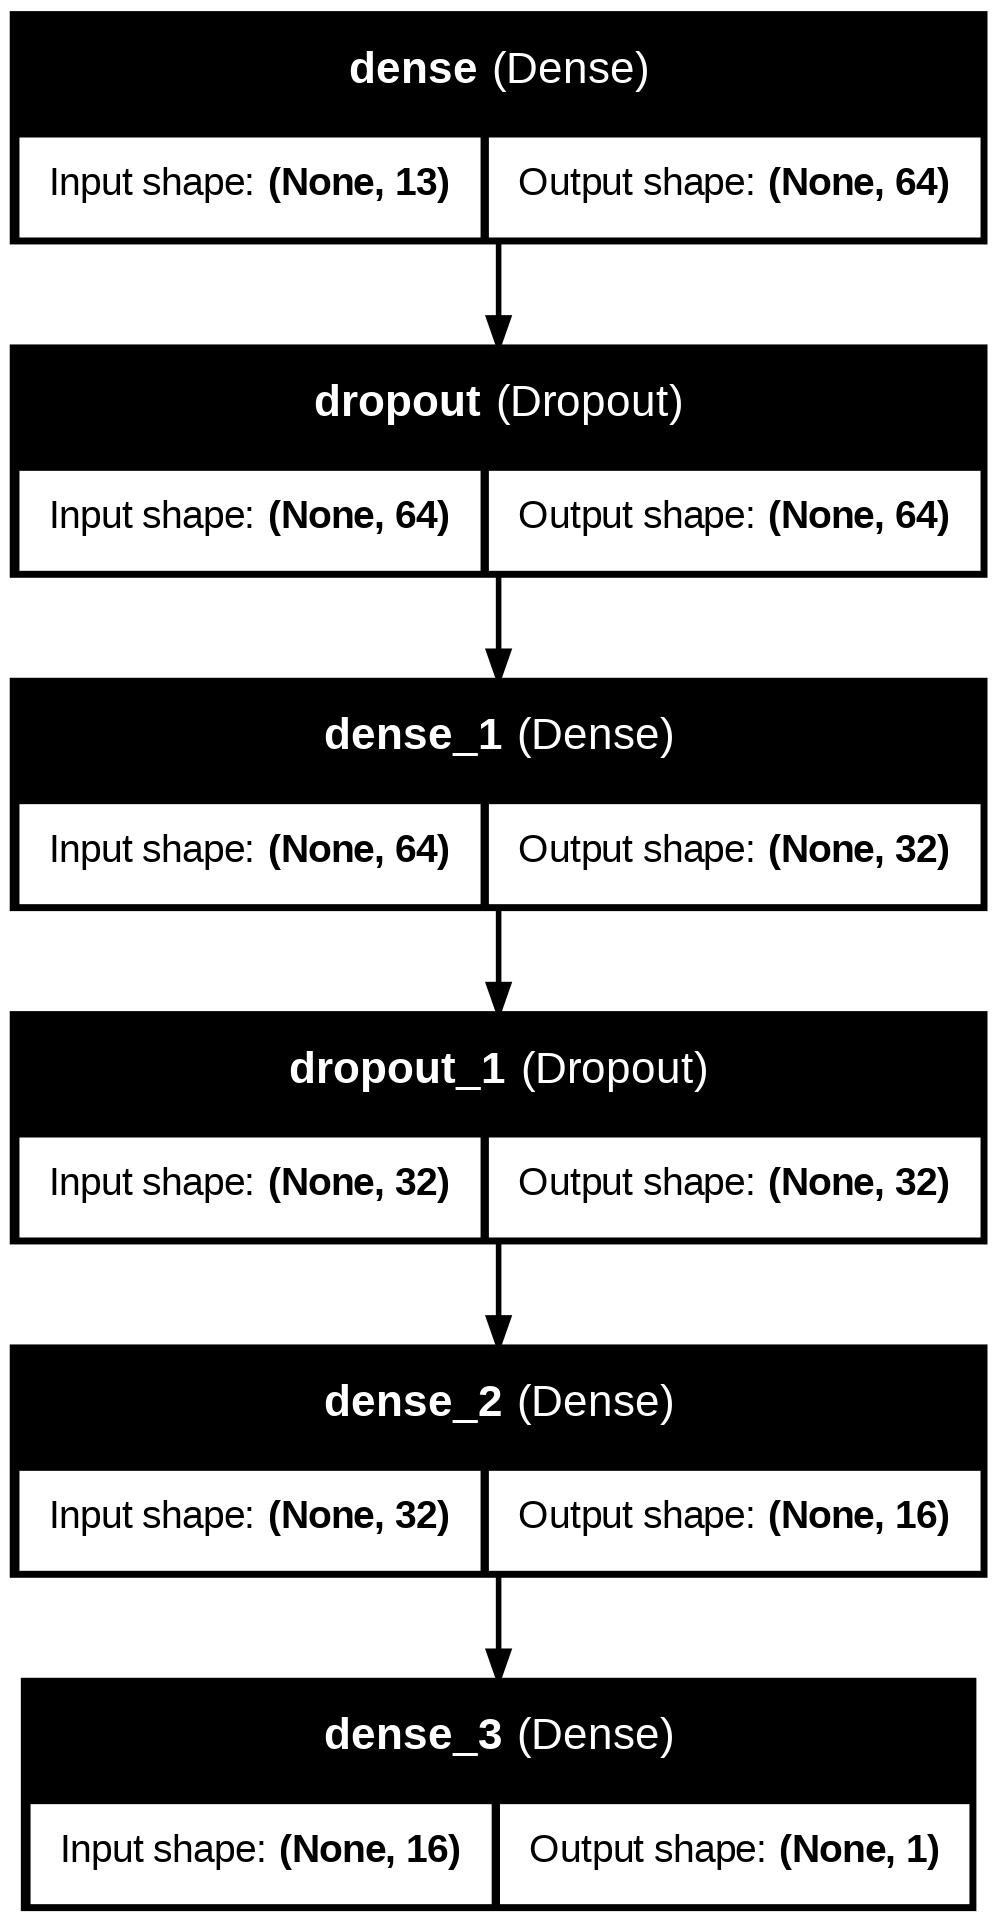

In [15]:
plot_model(fnn, show_shapes=True, show_layer_names=True)

* **Train model với Early Stopping tránh Overfitting**

In [16]:
fnn.compile(optimizer="adam", loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

fnn_history = fnn.fit(X_train_fnn, y_train_fnn, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0752 - mae: 0.2200 - val_loss: 0.0210 - val_mae: 0.1131
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0357 - mae: 0.1484 - val_loss: 0.0206 - val_mae: 0.1058
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0237 - mae: 0.1203 - val_loss: 0.0254 - val_mae: 0.1127
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - mae: 0.1020 - val_loss: 0.0241 - val_mae: 0.1088
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - mae: 0.1122 - val_loss: 0.0219 - val_mae: 0.1038
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0152 - mae: 0.0971 - val_loss: 0.0214 - val_mae: 0.1025
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0152 - mae: 0.0987 - val_loss: 0.0206 - val_mae: 0.0999
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0143 - mae: 0.0957 - val_loss: 0.0213 - val_mae: 0.1009
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

* **Biểu đồ quá trình huấn luyện**

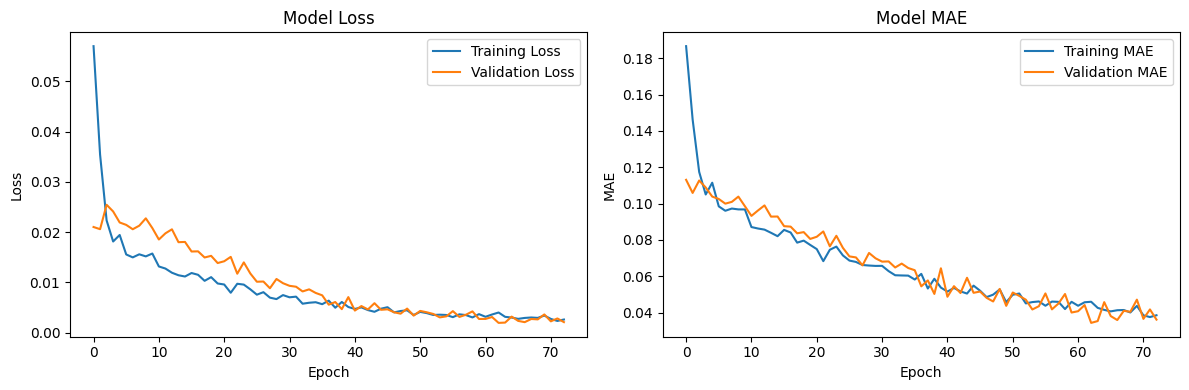

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(fnn_history.history['loss'], label='Training Loss')
plt.plot(fnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(fnn_history.history['mae'], label='Training MAE')
plt.plot(fnn_history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

* **Biểu đồ dự đoán của mô hình so với thực tế**

In [18]:
y_pred_fnn = fnn.predict(X_test_fnn)

y_test_fnn_original = scaler_y.inverse_transform(y_test_fnn)
y_pred_fnn_original = scaler_y.inverse_transform(y_pred_fnn)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


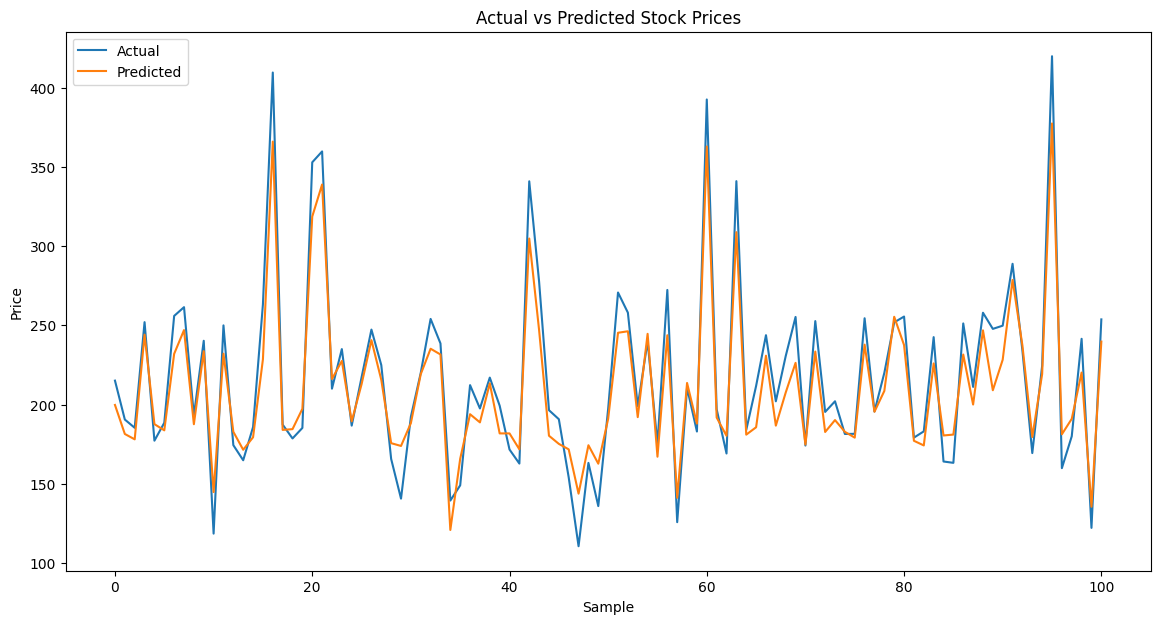

In [19]:
plt.figure(figsize=(14,7))
plt.plot(y_test_fnn_original, label='Actual')
plt.plot(y_pred_fnn_original, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

* **Đánh giá hiệu suất mô hình**

In [20]:
mse_fnn = mean_squared_error(y_test_fnn_original, y_pred_fnn_original)
rmse_fnn = root_mean_squared_error(y_test_fnn_original, y_pred_fnn_original)
mae_fnn = mean_absolute_error(y_test_fnn_original, y_pred_fnn_original)
r2_fnn = r2_score(y_test_fnn_original, y_pred_fnn_original)

print(f'MSE: {mse_fnn:.4f}')
print(f'RMSE: {rmse_fnn:.4f}')
print(f'MAE: {mae_fnn:.4f}')
print(f'R2: {r2_fnn:.4f}')

MSE: 306.3657
RMSE: 17.5033
MAE: 14.2954
R2: 0.9102


# **Xây dựng mô hình Recurrent Neural Network**


* **Chuẩn bị dữ liệu**

In [21]:
def create_sequences(X, y, sequence_length=10):
    X_data, y_data = [], []
    for i in range(len(X) - sequence_length):
        X_data.append(X[i:(i + sequence_length)])
        y_data.append(y[i + sequence_length])
    return np.array(X_data), np.array(y_data)

In [22]:
sequence_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

* **Chia tập train và test**

In [23]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

* **Xây dựng cấu trúc mạng**

In [24]:
rnn = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train_rnn.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* **Tóm tắt cấu trúc mạng**

In [25]:
rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,929 (128.63 KB)

 Trainable params: 32,929 (128.63 KB)

 Non-trainable params: 0 (0.00 B)

* **Trực quan hóa cấu trúc mạng**

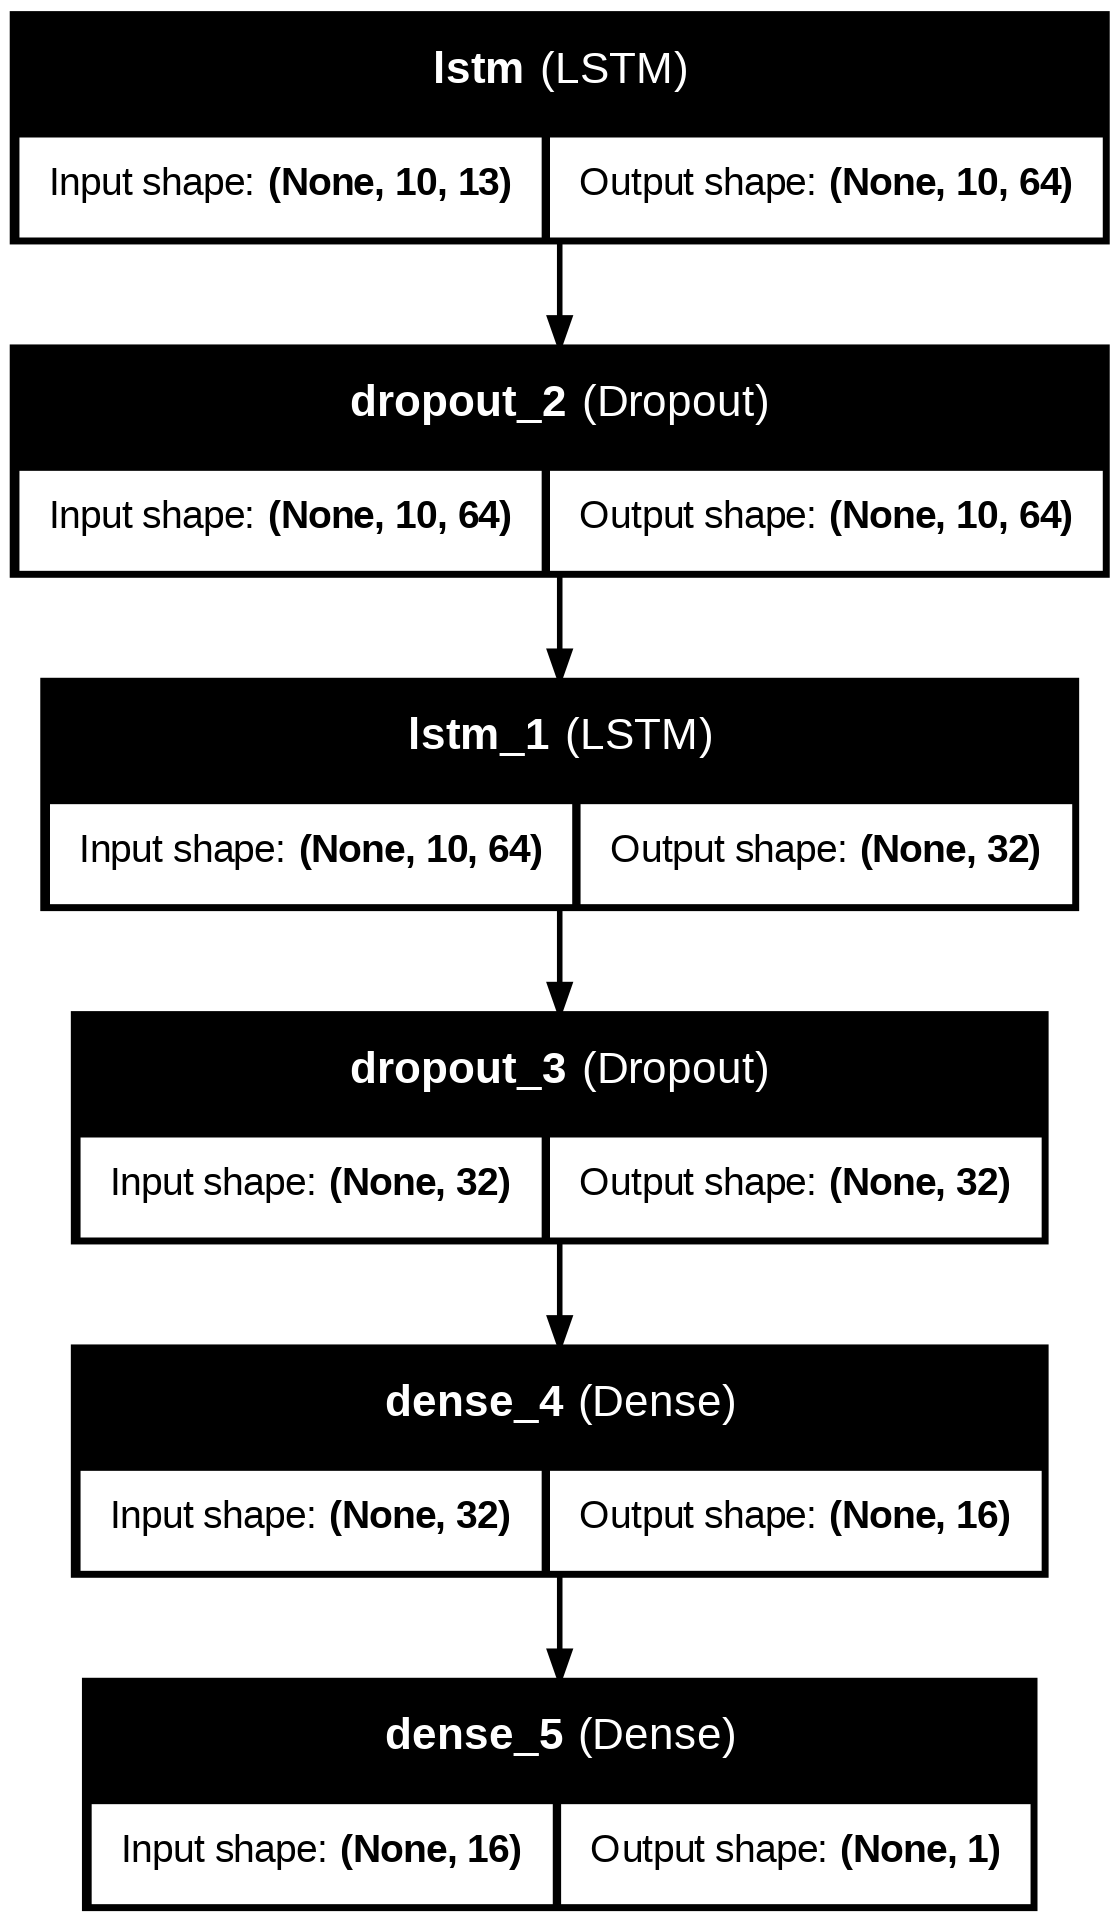

In [26]:
plot_model(rnn, show_shapes=True, show_layer_names=True)

* **Train model với Early Stopping**

In [27]:
rnn.compile(optimizer="adam", loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rnn_history = rnn.fit(X_train_rnn, y_train_rnn, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stopping], verbose=1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.1311 - mae: 0.3383 - val_loss: 0.0625 - val_mae: 0.2081
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0390 - mae: 0.1676 - val_loss: 0.0172 - val_mae: 0.0930
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0192 - mae: 0.1065 - val_loss: 0.0249 - val_mae: 0.1326
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0225 - mae: 0.1219 - val_loss: 0.0174 - val_mae: 0.0954
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0138 - mae: 0.0918 - val_loss: 0.0185 - val_mae: 0.0922
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0139 - mae: 0.0865 - val_loss: 0.0192 - val_mae: 0.0924
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0128 - mae: 0.0863 - val_loss: 0.0162 - val_mae: 0.0842
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102 - mae: 0.0789 - val_loss: 0.0151 - val_mae: 0.0830
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0111 - mae:

* **Biểu đồ quá trình huấn luyện**

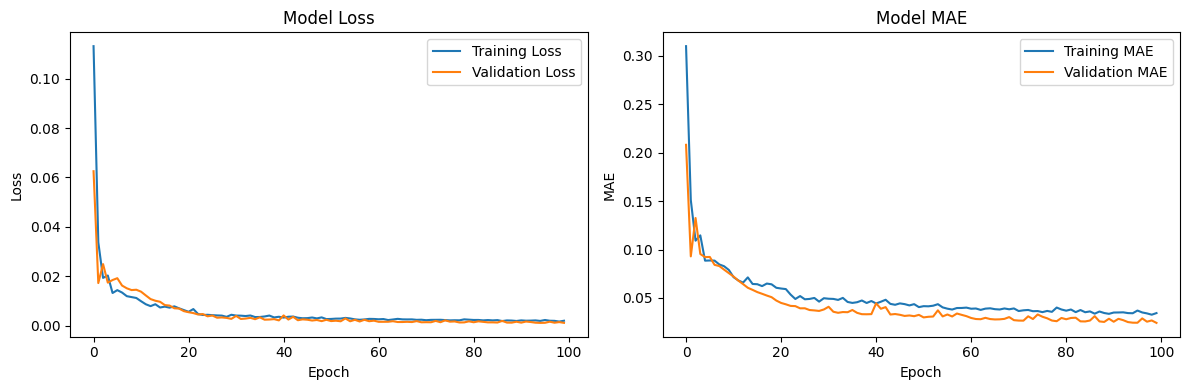

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rnn_history.history['mae'], label='Training MAE')
plt.plot(rnn_history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

* **Biểu đồ dự đoán của mô hình so với thực tế**

In [29]:
y_pred_rnn = rnn.predict(X_test_rnn)

y_test_rnn_original = scaler_y.inverse_transform(y_test_rnn)
y_pred_rnn_original = scaler_y.inverse_transform(y_pred_rnn)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


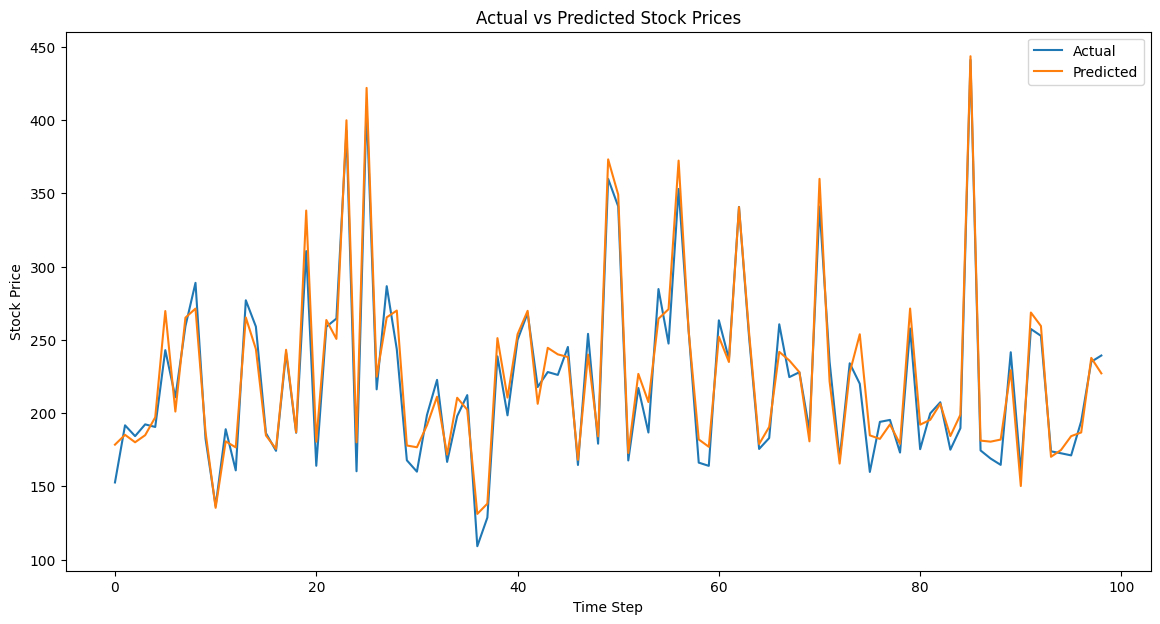

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_rnn_original, label="Actual")
plt.plot(y_pred_rnn_original, label="Predicted")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

* **Đánh giá hiệu suất mô hình**

In [31]:
mse_rnn = mean_squared_error(y_test_rnn_original, y_pred_rnn_original)
rmse_rnn = root_mean_squared_error(y_test_rnn_original, y_pred_rnn_original)
mae_rnn = mean_absolute_error(y_test_rnn_original, y_pred_rnn_original)
r2_rnn = r2_score(y_test_rnn_original, y_pred_rnn_original)

print(f'MSE: {mse_rnn:.4f}')
print(f'RMSE: {rmse_rnn:.4f}')
print(f'MAE: {mae_rnn:.4f}')
print(f'R2: {r2_rnn:.4f}')

MSE: 163.2824
RMSE: 12.7782
MAE: 10.5558
R2: 0.9555


# **Xây dựng mô hình học máy khác**

* **Chia tập train và test**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### **Linear Regression**



* **Xây dựng mô hình Linear Regression với Regularization tránh overfitting**

In [33]:
lr = Ridge(alpha=1.0)

lr.fit(X_train, y_train)

Ridge()

* **Biểu đồ Learning Curve**

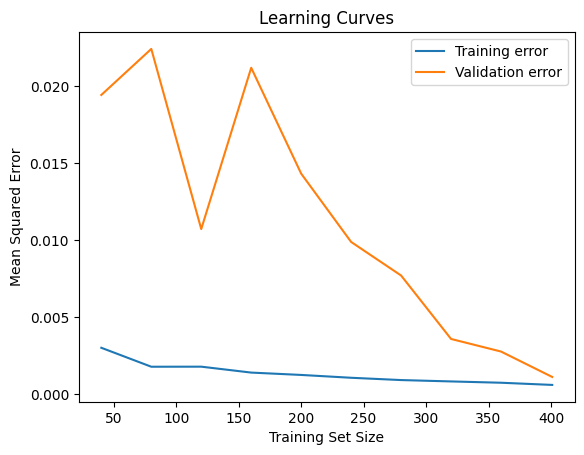

In [34]:
train_sizes, train_scores, val_scores = learning_curve(lr, X_scaled, y_scaled, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

* **Đánh giá hiệu suất mô hình**

In [35]:
y_pred_lr = lr.predict(X_test)

y_test_lr_original = scaler_y.inverse_transform(y_test)
y_pred_lr_original = scaler_y.inverse_transform(y_pred_lr)

In [36]:
mse_lr = mean_squared_error(y_test_lr_original, y_pred_lr_original)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_lr_original, y_pred_lr_original)
r2_lr = r2_score(y_test_lr_original, y_pred_lr_original)

print(f'MSE: {mse_lr:.4f}')
print(f'RMSE: {rmse_lr:.4f}')
print(f'MAE: {mae_lr:.4f}')
print(f'R2: {r2_lr:.4f}')

MSE: 72.5407
RMSE: 8.5171
MAE: 7.0131
R2: 0.9787


* **Biểu đồ dự đoán của mô hình so với thực tế**

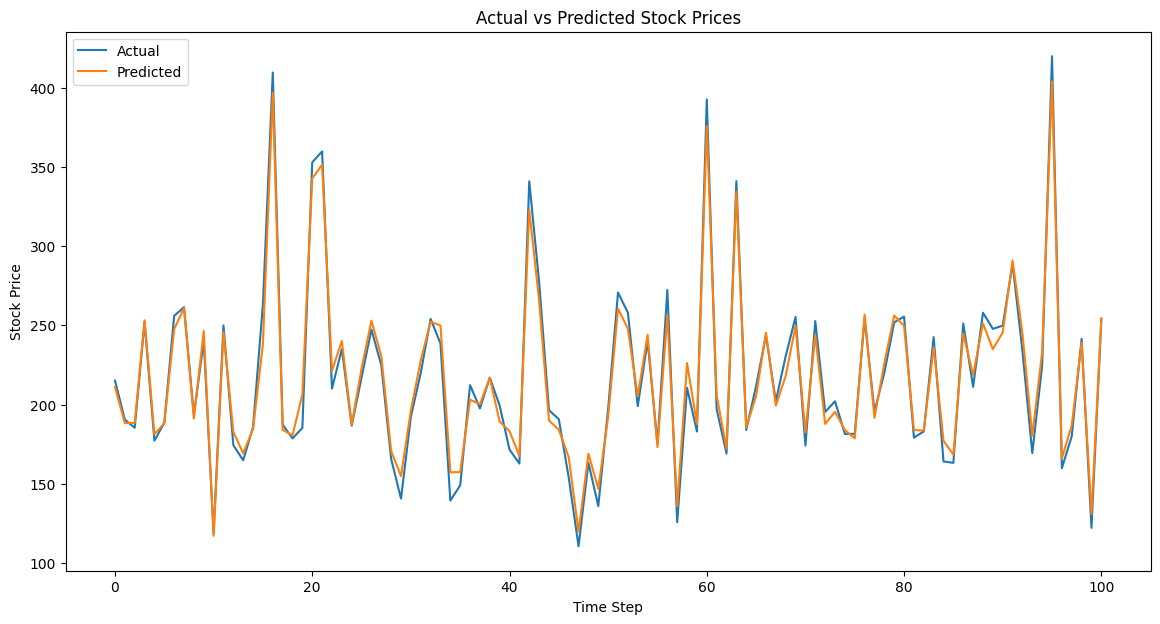

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_lr_original, label="Actual")
plt.plot(y_pred_lr_original, label="Predicted")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### **Support Vector Regression**

* **Xây dựng mô hình SVR - Hyperparameter Tuning tránh overfitting**

In [38]:
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

svr.fit(X_train, y_train.ravel())

SVR()

* **Biểu đồ Learning Curves**

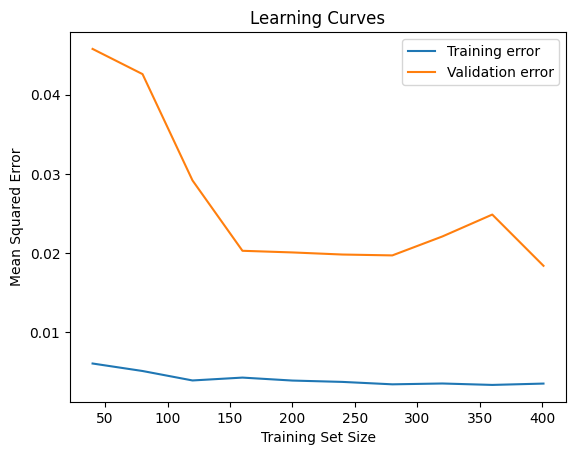

In [39]:
train_sizes, train_scores, val_scores = learning_curve(svr, X_scaled, y_scaled.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

* **Đánh giá hiệu suất mô hình**



In [40]:
y_pred_svr = svr.predict(X_test)

y_test_svr_original = scaler_y.inverse_transform(y_test)
y_pred_svr_original = scaler_y.inverse_transform(y_pred_svr.reshape(-1,1))

In [41]:
mse_svr = mean_squared_error(y_test_svr_original, y_pred_svr_original)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test_svr_original, y_pred_svr_original)
r2_svr = r2_score(y_test_svr_original, y_pred_svr_original)

print(f'MSE: {mse_svr:.4f}')
print(f'RMSE: {rmse_svr:.4f}')
print(f'MAE: {mae_svr:.4f}')
print(f'R2: {r2_svr:.4f}')

MSE: 565.8451
RMSE: 23.7875
MAE: 19.3043
R2: 0.8341


* **Biểu đồ dự đoán của mô hình so với thực tế**

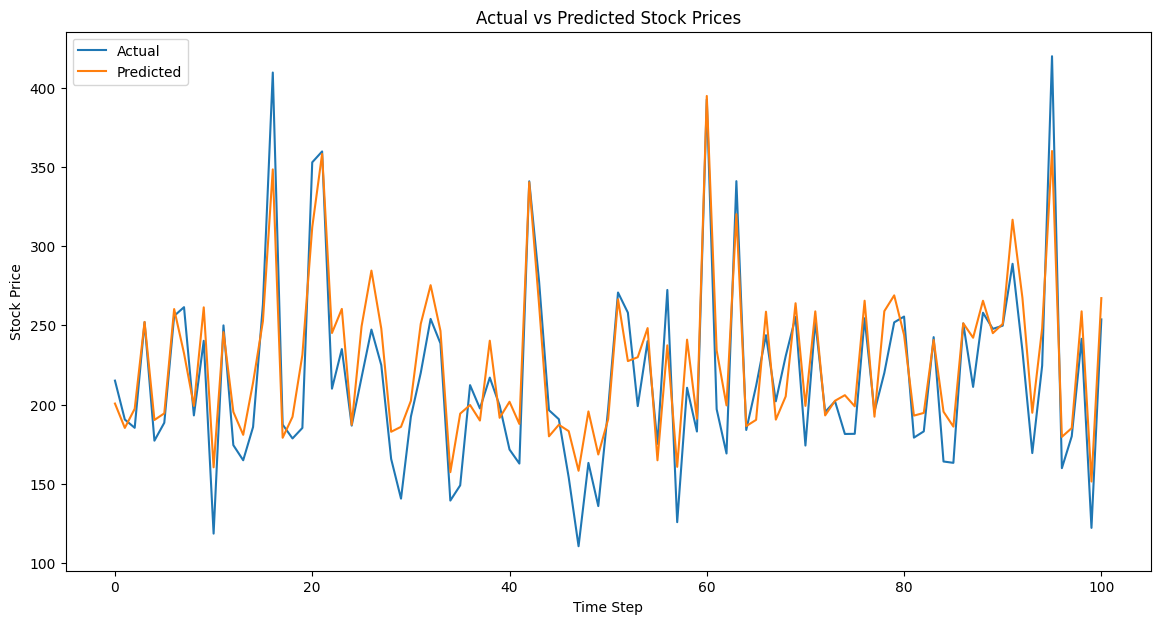

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_svr_original, label="Actual")
plt.plot(y_pred_svr_original, label="Predicted")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### **Decision Tree Regressor**

* **Xây dựng mô hình Decision Tree - Pruning tránh overfitting**

In [43]:
dsr = DecisionTreeRegressor(max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42)

dsr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

* **Biểu đồ Learning Curves**

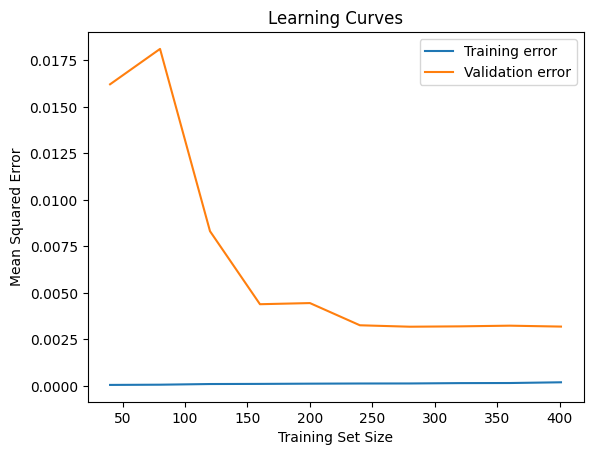

In [44]:
train_sizes, train_scores, val_scores = learning_curve(dsr, X_scaled, y_scaled, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

* **Đánh giá hiệu suất mô hình**

In [45]:
y_pred_dsr = dsr.predict(X_test)

y_test_dsr_original = scaler_y.inverse_transform(y_test)
y_pred_dsr_original = scaler_y.inverse_transform(y_pred_dsr.reshape(-1,1))

In [46]:
mse_dsr = mean_squared_error(y_test_dsr_original, y_pred_dsr_original)
rmse_dsr = np.sqrt(mse_dsr)
mae_dsr = mean_absolute_error(y_test_dsr_original, y_pred_dsr_original)
r2_dsr = r2_score(y_test_dsr_original, y_pred_dsr_original)

print(f'MSE: {mse_dsr:.4f}')
print(f'RMSE: {rmse_dsr:.4f}')
print(f'MAE: {mae_dsr:.4f}')
print(f'R2: {r2_dsr:.4f}')

MSE: 61.2455
RMSE: 7.8259
MAE: 5.2296
R2: 0.9820


* **Biểu đồ dự đoán của mô hình so với thực tế**

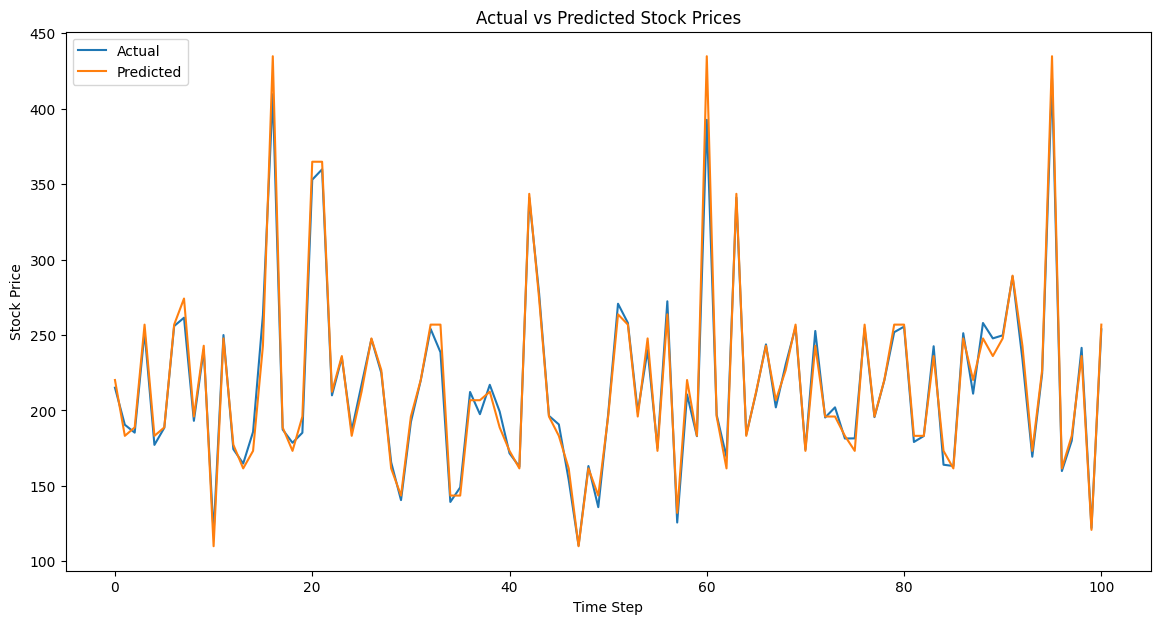

In [47]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_dsr_original, label="Actual")
plt.plot(y_pred_dsr_original, label="Predicted")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### **Random Forest Regressor**

* **Xây dụng mô hình Random Forest - Pruning tránh overfitting**

In [48]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

* **Biểu đồ Learning Curves**

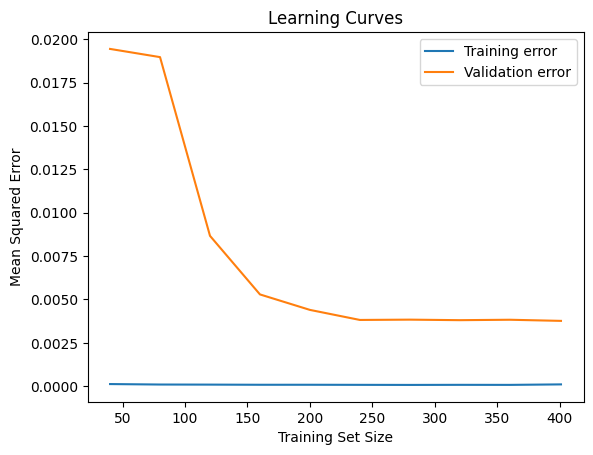

In [49]:
train_sizes, train_scores, val_scores = learning_curve(rfr, X_scaled, y_scaled.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

* **Đánh giá hiệu suất mô hình**

In [50]:
y_pred_rfr = rfr.predict(X_test)

y_test_rfr_original = scaler_y.inverse_transform(y_test)
y_pred_rfr_original = scaler_y.inverse_transform(y_pred_rfr.reshape(-1,1))

In [51]:
mse_rfr = mean_squared_error(y_test_rfr_original, y_pred_rfr_original)
rmse_rfr = np.sqrt(mse_rfr)
mae_rfr = mean_absolute_error(y_test_rfr_original, y_pred_rfr_original)
r2_rfr = r2_score(y_test_rfr_original, y_pred_rfr_original)

print(f'MSE: {mse_rfr:.4f}')
print(f'RMSE: {rmse_rfr:.4f}')
print(f'MAE: {mae_rfr:.4f}')
print(f'R2: {r2_rfr:.4f}')

MSE: 38.0796
RMSE: 6.1709
MAE: 4.8065
R2: 0.9888


* **Biểu đồ dự đoán của mô hình so với thực tế**

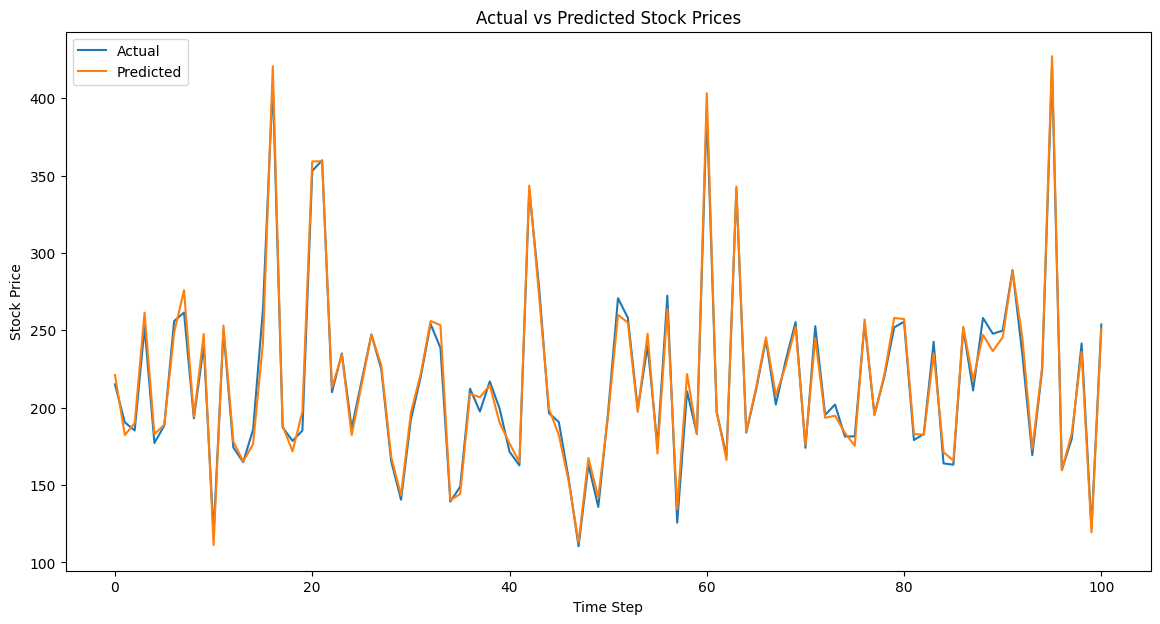

In [52]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_rfr_original, label="Actual")
plt.plot(y_pred_rfr_original, label="Predicted")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# **Đánh giá mô hình và so sánh các mô hình với nhau**

* **So sánh MSE, RMSE, MAE và R2**

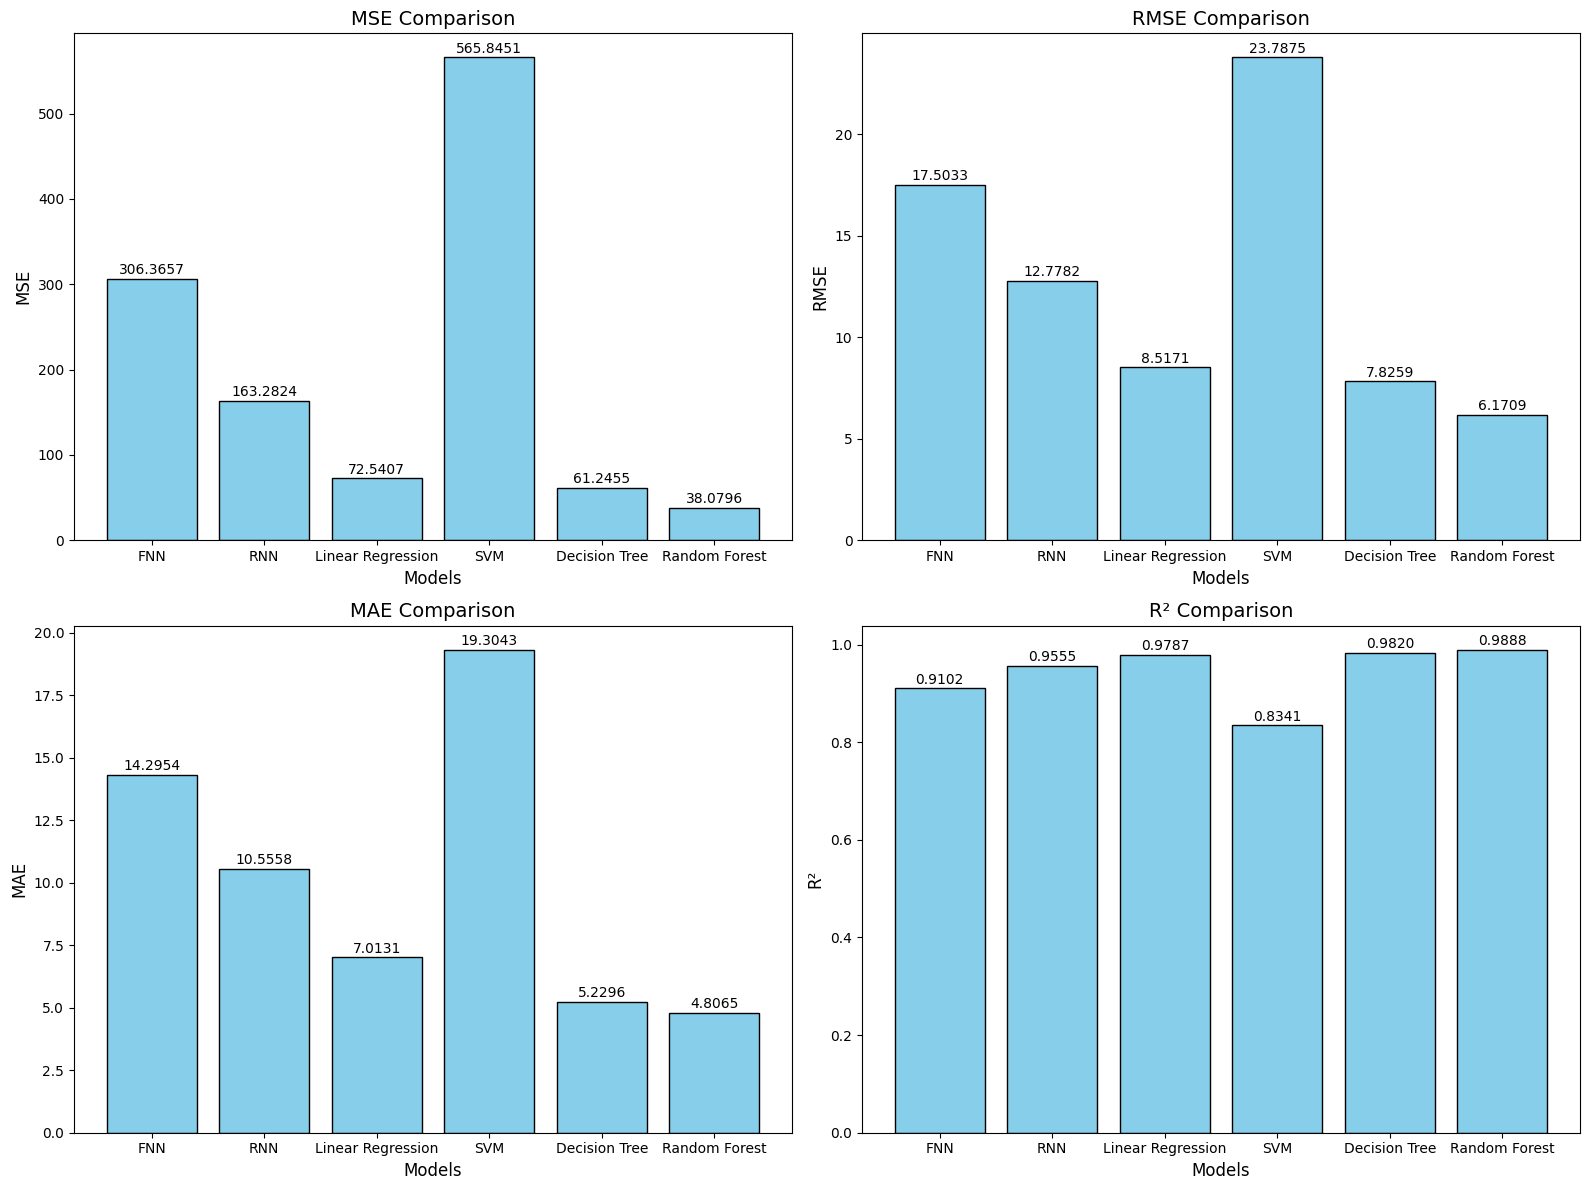

In [53]:
models = ["FNN", "RNN", "Linear Regression", "SVM", "Decision Tree", "Random Forest"]

mse = [mse_fnn, mse_rnn, mse_lr, mse_svr, mse_dsr, mse_rfr]
rmse = [rmse_fnn, rmse_rnn, rmse_lr, rmse_svr, rmse_dsr, rmse_rfr]
mae = [mae_fnn, mae_rnn, mae_lr, mae_svr, mae_dsr, mae_rfr]
r2 = [r2_fnn, r2_rnn, r2_lr, r2_svr, r2_dsr, r2_rfr]

metrics = [mse, rmse, mae, r2]
metric_names = ['MSE', 'RMSE', 'MAE', 'R²']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Increase figure size
axes = axes.flatten()

for i, ax in enumerate(axes):
    metric = metrics[i]
    ax.bar(models, metric, color='skyblue', edgecolor='black')

    for j, value in enumerate(metric):
        ax.text(j, value + 0.01 * max(metric), f'{value:.4f}', ha='center', fontsize=10)

    ax.set_title(f'{metric_names[i]} Comparison', fontsize=14)
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel(metric_names[i], fontsize=12)

plt.tight_layout()
plt.show()

* **So sánh dự đoán của mô hình so với thực tế***

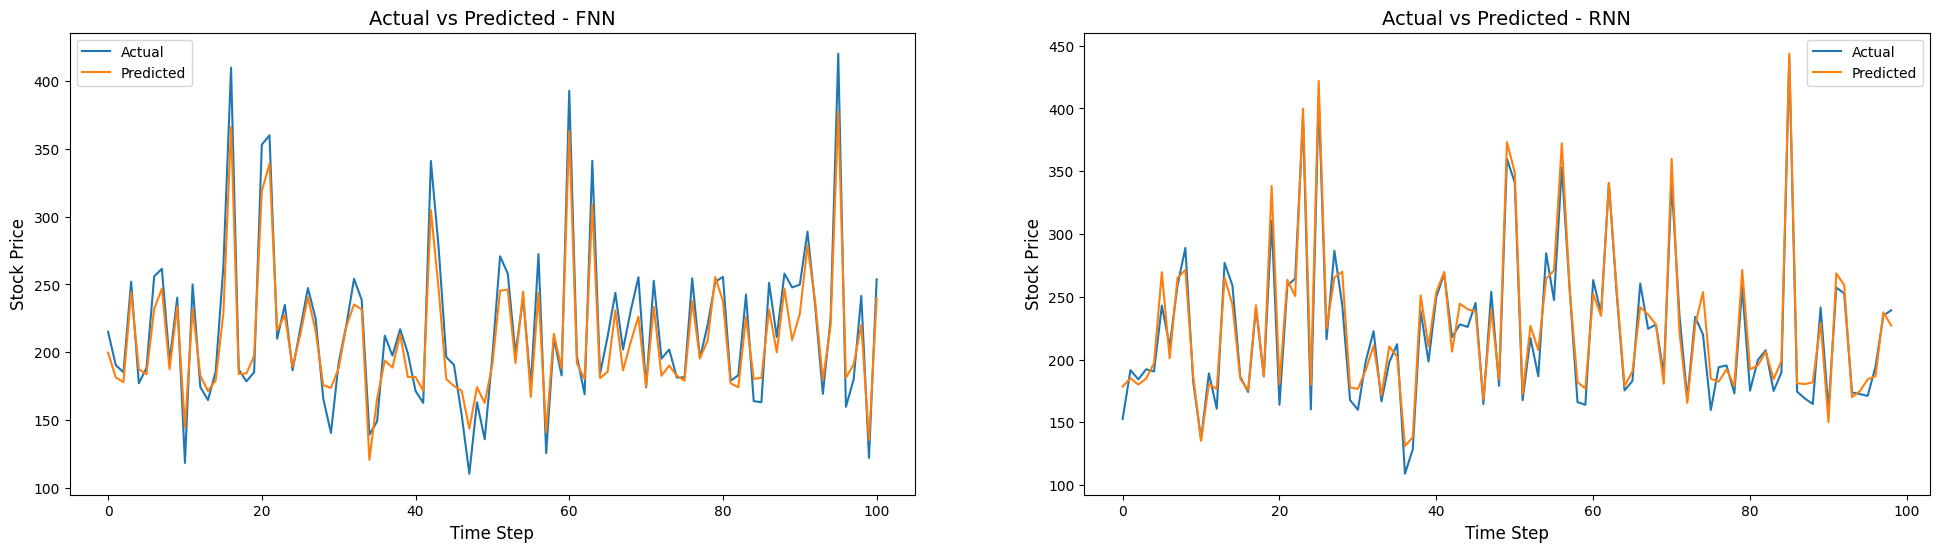

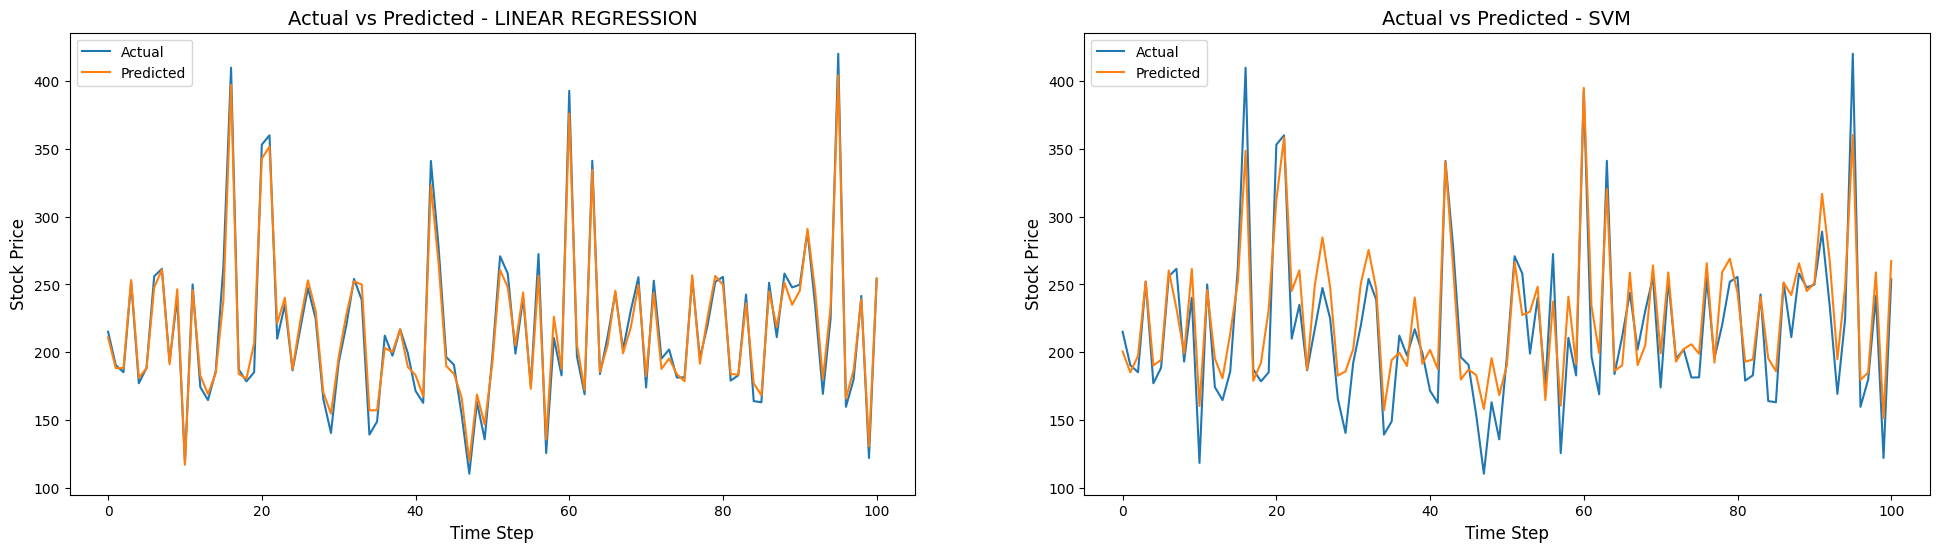

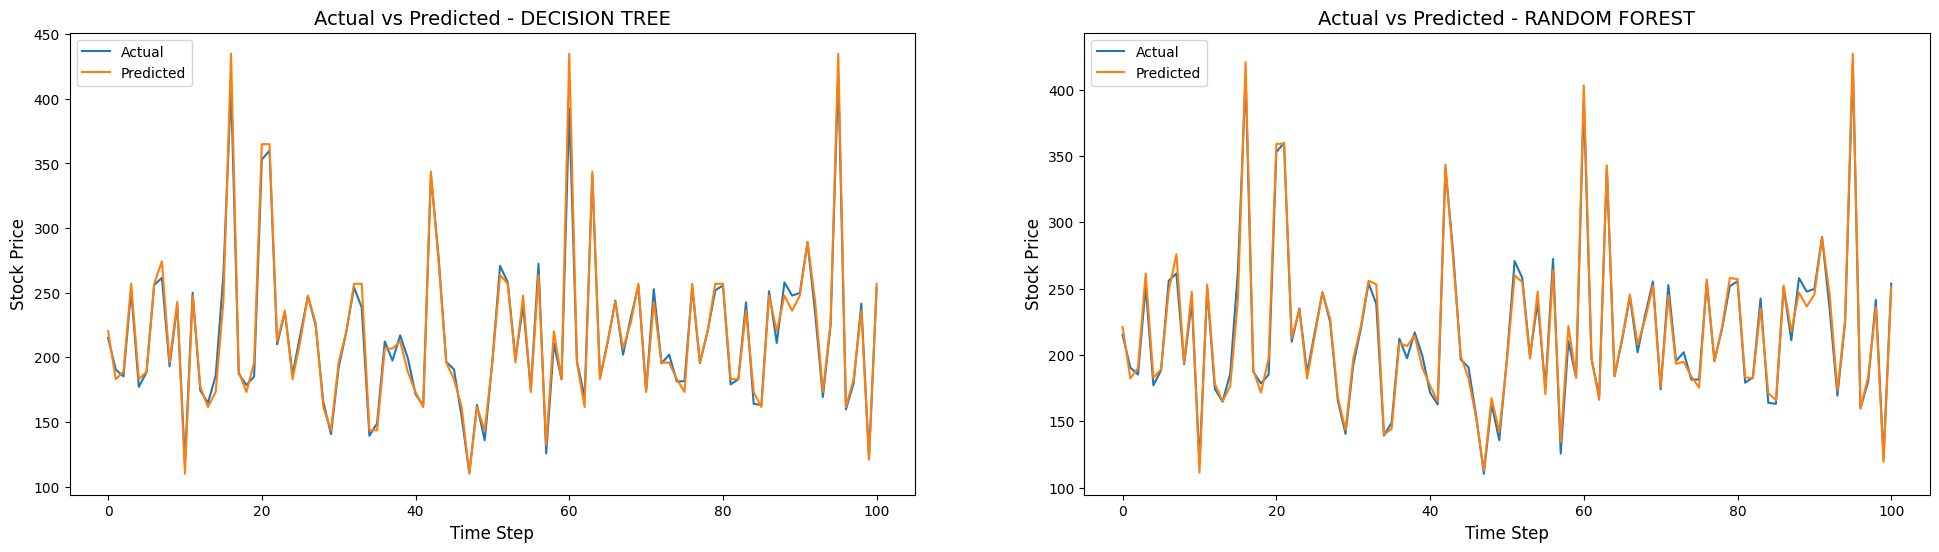

In [54]:
models = ["FNN", "RNN", "Linear Regression", "SVM", "Decision Tree", "Random Forest"]

y_test_plot = [y_test_fnn_original, y_test_rnn_original, y_test_lr_original, y_test_svr_original, y_test_dsr_original, y_test_rfr_original]
y_pred_plot = [y_pred_fnn_original, y_pred_rnn_original, y_pred_lr_original, y_pred_svr_original, y_pred_dsr_original, y_pred_rfr_original]

fig2, axes2 = plt.subplots(1, 2, figsize=(24, 6))
axes2 = axes2.flatten()

for i in range(2):
    axes2[i].plot(y_test_plot[i], label='Actual')
    axes2[i].plot(y_pred_plot[i], label='Predicted')
    axes2[i].set_title(f'Actual vs Predicted - {models[i].upper()}', fontsize=14)
    axes2[i].set_xlabel('Time Step', fontsize=12)
    axes2[i].set_ylabel('Stock Price', fontsize=12)
    axes2[i].legend()

fig3, axes3 = plt.subplots(1, 2, figsize=(24, 6))
axes3 = axes3.flatten()

for i in range(2, 4):
    axes3[i - 2].plot(y_test_plot[i], label='Actual')
    axes3[i - 2].plot(y_pred_plot[i], label='Predicted')
    axes3[i - 2].set_title(f'Actual vs Predicted - {models[i].upper()}', fontsize=14)
    axes3[i - 2].set_xlabel('Time Step', fontsize=12)
    axes3[i - 2].set_ylabel('Stock Price', fontsize=12)
    axes3[i - 2].legend()

fig4, axes4 = plt.subplots(1, 2, figsize=(24, 6))
axes4 = axes4.flatten()

for i in range(4, 6):
    axes4[i - 4].plot(y_test_plot[i], label='Actual')
    axes4[i - 4].plot(y_pred_plot[i], label='Predicted')
    axes4[i - 4].set_title(f'Actual vs Predicted - {models[i].upper()}', fontsize=14)
    axes4[i - 4].set_xlabel('Time Step', fontsize=12)
    axes4[i - 4].set_ylabel('Stock Price', fontsize=12)
    axes4[i - 4].legend()

plt.show()